# Data Acquisition

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Configuration ---
pkl_dir = "/kaggle/input/dataset-2"
output_csv = "combined_chest_data.csv"

# --- Load and combine data ---
all_subjects = []

# Get only the first 10 .pkl files
pkl_files = sorted([f for f in os.listdir(pkl_dir) if f.endswith(".pkl")])[:10]

for file in tqdm(pkl_files, desc="Processing first 10 files"):
    file_path = os.path.join(pkl_dir, file)
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')  # Fix for Python 2→3

        # Extract RespiBAN (chest) data
        chest = data['signal']['chest']
        subject = data['subject']
        labels = data['label']

        # --- KEY MODIFICATION: Filter labels 5/6/7 ---
        valid_mask = ~np.isin(labels, [5, 6, 7])  # True for valid labels (0–4)

        # Convert nested arrays to DataFrame columns (only valid rows)
        df = pd.DataFrame({
            'ACC_x': chest['ACC'][valid_mask, 0],
            'ACC_y': chest['ACC'][valid_mask, 1],
            'ACC_z': chest['ACC'][valid_mask, 2],
            'ECG': chest['ECG'][valid_mask].flatten(),
            'EMG': chest['EMG'][valid_mask].flatten(),
            'EDA': chest['EDA'][valid_mask].flatten(),
            'Temp': chest['Temp'][valid_mask].flatten(),
            'Resp': chest['Resp'][valid_mask].flatten(),
            'subject': [subject] * np.sum(valid_mask),
            'label': labels[valid_mask]
        })

        all_subjects.append(df)

# --- Combine into one DataFrame ---
combined_chest_df = pd.concat(all_subjects, ignore_index=True)

Processing first 10 files: 100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


In [2]:
combined_chest_df.columns

Index(['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp',
       'subject', 'label'],
      dtype='object')

In [3]:
# --- Save to CSV ---
# combined_chest_df.to_csv(output_csv, index=False)
print(f"Final DataFrame shape: {combined_chest_df.shape}")

Final DataFrame shape: (39237102, 10)


MAX freq. components

In [4]:
import numpy as np

def find_max_frequency(signal, fs, threshold=0.01):
    n = len(signal)
    if n == 0:
        return 0
    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(n, 1/fs)
    
    magnitude = np.abs(fft_vals)
    magnitude_norm = magnitude / np.max(magnitude)
    
    significant_freqs = fft_freqs[magnitude_norm > threshold]
    
    if len(significant_freqs) == 0:
        return 0
    else:
        return significant_freqs.max()

# Sampling frequency (update if different)
fs = 700

sensor_columns = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']

max_freqs_per_subject = {}

for subject_id, df_subj in combined_chest_df.groupby('subject'):
    max_freqs = {}
    for sensor in sensor_columns:
        signal = df_subj[sensor].dropna().values
        max_freq = find_max_frequency(signal, fs)
        max_freqs[sensor] = max_freq
    max_freqs_per_subject[subject_id] = max_freqs

# Print max frequencies per subject
for subject_id, freqs in max_freqs_per_subject.items():
    print(f"\nSubject: {subject_id}")
    for sensor, freq in freqs.items():
        print(f"  {sensor}: {freq:.4f} Hz")



Subject: S10
  ACC_x: 0.0037 Hz
  ACC_y: 1.8357 Hz
  ACC_z: 0.0354 Hz
  ECG: 99.8360 Hz
  EMG: 65.8188 Hz
  EDA: 0.0030 Hz
  Temp: 0.0000 Hz
  Resp: 1.6590 Hz

Subject: S11
  ACC_x: 0.0000 Hz
  ACC_y: 4.8937 Hz
  ACC_z: 0.0925 Hz
  ECG: 124.6652 Hz
  EMG: 79.8317 Hz
  EDA: 0.0008 Hz
  Temp: 0.0000 Hz
  Resp: 1.2183 Hz

Subject: S13
  ACC_x: 0.0015 Hz
  ACC_y: 1.1507 Hz
  ACC_z: 0.1851 Hz
  ECG: 105.1271 Hz
  EMG: 92.2072 Hz
  EDA: 0.0022 Hz
  Temp: 0.0000 Hz
  Resp: 1.6395 Hz

Subject: S14
  ACC_x: 0.0022 Hz
  ACC_y: 2.7995 Hz
  ACC_z: 0.0582 Hz
  ECG: 135.9289 Hz
  EMG: 199.3188 Hz
  EDA: 0.0004 Hz
  Temp: 0.0000 Hz
  Resp: 1.3793 Hz

Subject: S15
  ACC_x: 0.0033 Hz
  ACC_y: 0.7389 Hz
  ACC_z: 0.2807 Hz
  ECG: 108.3924 Hz
  EMG: 155.0975 Hz
  EDA: 0.0031 Hz
  Temp: 0.0000 Hz
  Resp: 1.4075 Hz

Subject: S16
  ACC_x: 0.0000 Hz
  ACC_y: 0.8249 Hz
  ACC_z: 0.2598 Hz
  ECG: 119.7055 Hz
  EMG: 73.4431 Hz
  EDA: 0.0029 Hz
  Temp: 0.0000 Hz
  Resp: 1.6398 Hz

Subject: S17
  ACC_x: 0.0090 Hz


# 400Hz Downsampling

In [5]:
import numpy as np
import pandas as pd
from scipy.signal import decimate

# --- Setup ---
fs = 700  # original sampling rate in Hz
target_fs = 400  # desired fixed downsample rate
downsample_factor = int(fs // target_fs)

sensor_columns = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
downsampled_subject_dfs = []

for subject_id, df_subj in combined_chest_df.groupby('subject'):
    downsampled_sensors = {}
    max_len = None

    for sensor in sensor_columns:
        signal = df_subj[sensor].dropna().values
        
        if downsample_factor > 1:
            downsampled_signal = decimate(signal, downsample_factor, ftype='fir', zero_phase=True)
        else:
            downsampled_signal = signal
        
        downsampled_sensors[sensor] = downsampled_signal

        if max_len is None:
            max_len = len(downsampled_signal)
        else:
            max_len = min(max_len, len(downsampled_signal))

    # --- Downsample Labels ---
    labels = df_subj['label'].values
    downsampled_labels = labels[::downsample_factor][:max_len]

    # --- Align all signals to min length ---
    for sensor in sensor_columns:
        downsampled_sensors[sensor] = downsampled_sensors[sensor][:max_len]

    df_downsampled_subj = pd.DataFrame(downsampled_sensors)
    df_downsampled_subj['subject'] = subject_id
    df_downsampled_subj['label'] = downsampled_labels
    df_downsampled_subj['time'] = np.arange(max_len) / target_fs

    downsampled_subject_dfs.append(df_downsampled_subj)

# --- Combine all ---
df1 = pd.concat(downsampled_subject_dfs, ignore_index=True)

df1.head(10)


,ACC_x,ACC_y,ACC_z,ECG,EMG,EDA,Temp,Resp,subject,label,time
0,1.1278,0.1520,0.3416,-1.333694,-0.013687,0.716019,33.695862,0.213623,S10,0,0.0000
1,1.0932,0.1888,0.2922,-1.327744,-0.021927,0.714493,33.741333,0.192261,S10,0,0.0025
2,1.0354,0.2094,0.1858,-1.322067,-0.009018,0.715637,33.717072,0.205994,S10,0,0.0050
3,0.9666,0.2118,0.0412,-1.316345,-0.002380,0.714874,33.741333,0.193787,S10,0,0.0075
4,0.8916,0.2040,-0.1228,-1.310257,0.001053,0.715256,33.747406,0.172424,S10,0,0.0100
5,0.8358,0.1978,-0.3018,-1.304306,-0.008972,0.713730,33.744385,0.181580,S10,0,0.0125
6,0.8042,0.1906,-0.4724,-1.298950,-0.037399,0.712967,33.753479,0.196838,S10,0,0.0150
7,0.7880,0.1834,-0.6210,-1.292908,-0.045181,0.713730,33.717072,0.157166,S10,0,0.0175
8,0.7880,0.1742,-0.7352,-1.287277,-0.045135,0.711441,33.730713,0.138855,S10,0,0.0200
9,0.7968,0.1642,-0.8110,-1.281830,-0.046829,0.712585,33.729218,0.160217,S10,0,0.0225


In [6]:
df1['label'].value_counts()

label
0    18254600
1     8188602
4     5492198
2     4701201
3     2600501
Name: count, dtype: int64

In [7]:
df1.columns

Index(['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp',
       'subject', 'label', 'time'],
      dtype='object')

In [8]:
pip install numpy scipy neurokit2 antropy heartpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.
mlxtend 0.23.4 requir

In [10]:
df1=df1.drop(columns=['subject','time'])

# Feature Extraction

In [11]:
def extract_features(df_window, sensor_columns):
    """
    Extract features from a window of sensor data with comprehensive error handling
    """
    features = {}
    epsilon = 1e-10  # Small positive constant to prevent division by zero
    
    # Helper function to get sensor data
    def get_sensor_data(sensor_prefix):
        return [col for col in sensor_columns if col.startswith(sensor_prefix)]
    
    # Helper function to safely calculate sampling frequency
    def get_sampling_frequency():
        try:
            time_diff = (df_window.index[1] - df_window.index[0]).total_seconds()
            return 1/max(time_diff, epsilon)
        except:
            return 1/epsilon  # Fallback value
    
    # ACC features (4 features)
    acc_cols = get_sensor_data('ACC')
    if acc_cols:
        for axis in ['x', 'y', 'z']:
            axis_col = next((col for col in acc_cols if axis in col.lower()), None)
            if axis_col and len(df_window[axis_col]) > 1:  # Need at least 2 samples
                acc_data = df_window[axis_col].dropna()
                if len(acc_data) < 2:
                    continue
                    
                features[f'ACC_{axis}_mean'] = acc_data.mean()
                features[f'ACC_{axis}_std'] = acc_data.std()
                features[f'ACC_{axis}_abs_integral'] = np.trapz(np.abs(acc_data))
                
                try:
                    fs = get_sampling_frequency()
                    f, Pxx = signal.welch(acc_data, fs=fs)
                    features[f'ACC_{axis}_peak_freq'] = f[np.argmax(Pxx)] if len(Pxx) > 0 else 0
                except:
                    features[f'ACC_{axis}_peak_freq'] = 0
    
    # ECG features (17 features)
    ecg_cols = get_sensor_data('ECG')
    if ecg_cols and len(df_window[ecg_cols[0]]) > 1:
        ecg_data = df_window[ecg_cols[0]].dropna()
        if len(ecg_data) > 1:
            # Time-domain HRV features
            rr_intervals = np.diff(ecg_data.index).astype('timedelta64[s]').astype(float)
            valid_rr = rr_intervals > 0
            
            features['ECG_HR_mean'] = 60/np.mean(rr_intervals[valid_rr]) if np.any(valid_rr) else 0
            features['ECG_SDNN'] = np.std(rr_intervals[valid_rr]) if np.any(valid_rr) else 0
            
            if len(rr_intervals) > 1:
                diff_rr = np.diff(rr_intervals)
                features['ECG_RMSSD'] = np.sqrt(np.mean(np.square(diff_rr)))
                nn50 = np.sum(np.abs(diff_rr) > 0.05)
                features['ECG_NN50'] = nn50
                features['ECG_pNN50'] = nn50/len(diff_rr) if len(diff_rr) > 0 else 0
                features['ECG_TINN'] = np.percentile(rr_intervals, 75) - np.percentile(rr_intervals, 25)
            else:
                for f in ['ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50', 'ECG_TINN']:
                    features[f] = 0
            
            # Frequency-domain HRV features
            try:
                fs = get_sampling_frequency()
                f, Pxx = signal.welch(ecg_data, fs=fs)
                
                vlf_band = (0.003, 0.04)
                lf_band = (0.04, 0.15)
                hf_band = (0.15, 0.4)
                
                vlf_power = np.trapz(Pxx[(f >= vlf_band[0]) & (f < vlf_band[1])])
                lf_power = np.trapz(Pxx[(f >= lf_band[0]) & (f < lf_band[1])])
                hf_power = np.trapz(Pxx[(f >= hf_band[0]) & (f < hf_band[1])])
                total_power = vlf_power + lf_power + hf_power + epsilon
                
                features.update({
                    'ECG_VLF_energy': vlf_power,
                    'ECG_LF_energy': lf_power,
                    'ECG_HF_energy': hf_power,
                    'ECG_LF_HF_ratio': lf_power/(hf_power + epsilon),
                    'ECG_LF_norm': lf_power/total_power,
                    'ECG_HF_norm': hf_power/total_power,
                    'ECG_relative_power': (lf_power + hf_power)/total_power
                })
            except:
                for f in ['ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
                         'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power']:
                    features[f] = 0
            
            # Nonlinear features
            if len(rr_intervals) > 1:
                try:
                    diff_rr = np.diff(rr_intervals)
                    sd1 = np.std(diff_rr)/np.sqrt(2)
                    sd2 = np.std(rr_intervals[:-1] + rr_intervals[1:])/np.sqrt(2)
                    hist, _ = np.histogram(rr_intervals, bins='auto')
                    features.update({
                        'ECG_SD1': sd1,
                        'ECG_SD2': sd2,
                        'ECG_entropy': entropy(hist) if np.any(hist) else 0
                    })
                except:
                    for f in ['ECG_SD1', 'ECG_SD2', 'ECG_entropy']:
                        features[f] = 0

    # EDA features (12 features)
    eda_cols = get_sensor_data('EDA')
    if eda_cols and len(df_window[eda_cols[0]]) > 1:
        eda_data = df_window[eda_cols[0]].dropna()
        if len(eda_data) > 1:
            features['EDA_mean'] = eda_data.mean()
            features['EDA_std'] = eda_data.std()
            
            try:
                peaks, _ = find_peaks(eda_data, height=0.05, distance=10)
                features['EDA_SCR_count'] = len(peaks)
                features['EDA_SCR_amplitude'] = np.mean(eda_data.iloc[peaks]) if len(peaks) > 0 else 0
                features['EDA_SCR_duration'] = len(eda_data)/max(len(peaks), 1)
                features['EDA_SCR_slope'] = np.mean(np.gradient(eda_data.iloc[peaks])) if len(peaks) > 0 else 0
                features['EDA_dynamic_range'] = eda_data.max() - eda_data.min()
            except:
                for f in ['EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration', 
                         'EDA_SCR_slope', 'EDA_dynamic_range']:
                    features[f] = 0

    # EMG features (14 features)
    emg_cols = get_sensor_data('EMG')
    if emg_cols and len(df_window[emg_cols[0]]) > 1:
        emg_data = df_window[emg_cols[0]].dropna()
        if len(emg_data) > 1:
            features['EMG_mean'] = emg_data.mean()
            features['EMG_std'] = emg_data.std()
            features['EMG_dynamic_range'] = emg_data.max() - emg_data.min()
            
            try:
                zero_crossings = np.where(np.diff(np.sign(emg_data - emg_data.mean())))[0]
                features['EMG_ZCR'] = len(zero_crossings)/len(emg_data)
                
                peaks, _ = find_peaks(emg_data, height=emg_data.mean() + emg_data.std())
                features.update({
                    'EMG_peaks': len(peaks),
                    'EMG_signal_energy': np.sum(emg_data**2),
                    'EMG_amplitude_mean': np.mean(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_std': np.std(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_max': np.max(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,
                    'EMG_amplitude_min': np.min(emg_data.iloc[peaks]) if len(peaks) > 0 else 0,

                })
            except:
                for f in ['EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
                         'EMG_amplitude_mean', 'EMG_amplitude_std',
                         'EMG_amplitude_max', 'EMG_amplitude_min']:
                    features[f] = 0

    # RESP features (7 features)
    resp_cols = get_sensor_data('Resp')
    if resp_cols and len(df_window[resp_cols[0]]) > 1:
        resp_data = df_window[resp_cols[0]].dropna()
        if len(resp_data) > 1:
            try:
                peaks, _ = find_peaks(resp_data)
                valleys, _ = find_peaks(-resp_data)
                
                if len(peaks) > 1 and len(valleys) > 1:
                    inhale_durations = np.diff(valleys)
                    exhale_durations = np.diff(peaks)
                    time_unit = (df_window.index[1] - df_window.index[0]).total_seconds()
                    
                    features.update({
                        'Resp_inhale_mean': np.mean(inhale_durations),
                        'Resp_inhale_std': np.std(inhale_durations),
                        'Resp_exhale_mean': np.mean(exhale_durations),
                        'Resp_exhale_std': np.std(exhale_durations),
                        'Resp_duration_ratio': np.mean(inhale_durations)/max(np.mean(exhale_durations), epsilon),
                        'Resp_stretch': np.mean(resp_data[peaks]) - np.mean(resp_data[valleys]),
                        'Resp_rate': 60/(max(np.mean(np.diff(peaks)) * time_unit, epsilon))
                    })
                else:
                    for f in ['Resp_inhale_mean', 'Resp_inhale_std', 'Resp_exhale_mean',
                             'Resp_exhale_std', 'Resp_duration_ratio', 'Resp_stretch', 'Resp_rate']:
                        features[f] = 0
            except:
                for f in ['Resp_inhale_mean', 'Resp_inhale_std', 'Resp_exhale_mean',
                         'Resp_exhale_std', 'Resp_duration_ratio', 'RESP_stretch', 'RESP_rate']:
                    features[f] = 0

    # TEMP features (6 features)
    temp_cols = get_sensor_data('Temp')
    if temp_cols and len(df_window[temp_cols[0]]) > 1:
        temp_data = df_window[temp_cols[0]].dropna()
        if len(temp_data) > 1:
            features.update({
                'Temp_mean': temp_data.mean(),
                'Temp_std': temp_data.std(),
                'Temp_min': temp_data.min(),
                'Temp_max': temp_data.max(),
                'Temp_range': temp_data.max() - temp_data.min()
            })
            
            try:
                x = np.arange(len(temp_data))
                slope, _, _, _, _ = stats.linregress(x, temp_data)
                features['Temp_slope'] = slope
            except:
                features['Temp_slope'] = 0
    
    return features

# Rolling Windows

In [12]:
def process_rolling_windows(df, sampling_rate=400, window_size_sec=60, overlap=0.5, verbose=True):
    """
    Process dataframe using fixed sampling rate
    
    Args:
        df: Input DataFrame (must be time-indexed)
        sampling_rate: Samples per second (400Hz)
        window_size_sec: Window duration in seconds
        overlap: Fraction of window overlap (0-1)
        verbose: Whether to show progress
    """
    # Validate input
    if len(df) == 0:
        raise ValueError("Input dataframe is empty")
    
    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except Exception as e:
            raise ValueError(f"Could not convert index to datetime: {str(e)}")
    
    # Calculate window parameters
    window_size_samples = int(window_size_sec * sampling_rate)
    step_size_samples = int(window_size_samples * (1 - overlap))
    total_samples = len(df)
    
    if window_size_samples > total_samples:
        raise ValueError(f"Window size ({window_size_samples} samples) exceeds data length ({total_samples} samples)")
    
    # Calculate total windows
    total_windows = ((total_samples - window_size_samples) // step_size_samples) + 1
    
    if verbose:
        print(f"Processing {total_windows} windows ({window_size_sec}s at {sampling_rate}Hz, {overlap*100}% overlap)")
    
    # Process each window
    results = []
    for i in range(total_windows):
        start_idx = i * step_size_samples
        end_idx = start_idx + window_size_samples
        window_df = df.iloc[start_idx:end_idx]
        
        if len(window_df) == window_size_samples:
            results.append(window_df)  # Just store the window for this simplified version
            
        if verbose and (i+1) % max(1, total_windows//10) == 0:  # Update every ~10%
            print(f"Processed {i+1}/{total_windows} windows ({(i+1)/total_windows*100:.1f}%)")
    
    if verbose:
        print(f"Completed {len(results)}/{total_windows} windows")
    
    return results

In [13]:
def extract_features_from_data(df1):
    """
    Extract features using sliding window of 30sec with 50% overlap on df1 and store in df2
    
    Args:
        df1: Input DataFrame with sensor data
        df2: Output DataFrame to store extracted features
    """
    # Get sensor columns (assuming all columns except potential non-sensor ones)
    sensor_columns = [col for col in df1.columns if col in ['ACC_x', 'ACC_y', 'ACC_z', 
                                                          'ECG', 'EDA', 'EMG', 'Resp', 'Temp']]
    
    # Process with 30-second windows and 50% overlap
    windows = process_rolling_windows(
        df=df1,
        window_size_sec=30,
        overlap=0.5,
        verbose=True
    )
    
    # Extract features for each window
    features_list = []
    for window_df in windows:
        features = extract_features(window_df, sensor_columns)
        features_list.append(features)
        # Assign mode label for current window
        label_mode = window_df['label'].mode()
        features['label'] = label_mode[0] if not label_mode.empty else np.nan
    
    # Convert to DataFrame and store in df2
    df2 = pd.DataFrame(features_list)
    
    return df2

In [14]:
# Assuming df1 contains your raw sensor data and df2 will store the features
df2 = extract_features_from_data(df1)

Processing 6538 windows (30s at 400Hz, 50.0% overlap)
Processed 653/6538 windows (10.0%)
Processed 1306/6538 windows (20.0%)
Processed 1959/6538 windows (30.0%)
Processed 2612/6538 windows (40.0%)
Processed 3265/6538 windows (49.9%)
Processed 3918/6538 windows (59.9%)
Processed 4571/6538 windows (69.9%)
Processed 5224/6538 windows (79.9%)
Processed 5877/6538 windows (89.9%)
Processed 6530/6538 windows (99.9%)
Completed 6538/6538 windows


In [15]:
df2.head()

,ACC_x_mean,ACC_x_std,ACC_x_abs_integral,ACC_x_peak_freq,ACC_y_mean,ACC_y_std,ACC_y_abs_integral,ACC_y_peak_freq,ACC_z_mean,ACC_z_std,...,Resp_duration_ratio,RESP_stretch,RESP_rate,Temp_mean,Temp_std,Temp_min,Temp_max,Temp_range,Temp_slope,label
0,0.876836,0.014338,10521.027609,0,0.021927,0.025458,283.828795,0,-0.272395,0.063769,...,0,0,0,33.745495,0.024995,33.659485,33.902283,0.242798,0,0
1,0.878254,0.004702,10538.172310,0,0.003419,0.008423,69.159378,0,-0.272993,0.018724,...,0,0,0,33.770809,0.029185,33.680695,33.925049,0.244354,0,0
2,0.883957,0.033430,10606.554203,0,0.017175,0.071681,560.840285,0,-0.236976,0.056655,...,0,0,0,33.794304,0.025404,33.706482,33.932678,0.226196,0,0
3,0.889101,0.050159,10668.318403,0,0.029089,0.096158,1018.535599,0,-0.207139,0.057198,...,0,0,0,33.794327,0.024747,33.714050,33.932678,0.218628,0,0
4,0.884423,0.043140,10612.122704,0,0.017364,0.080228,731.996706,0,-0.234572,0.054427,...,0,0,0,33.787811,0.023671,33.667084,33.928101,0.261017,0,0


In [16]:
df2.columns

Index(['ACC_x_mean', 'ACC_x_std', 'ACC_x_abs_integral', 'ACC_x_peak_freq',
       'ACC_y_mean', 'ACC_y_std', 'ACC_y_abs_integral', 'ACC_y_peak_freq',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_abs_integral', 'ACC_z_peak_freq',
       'ECG_HR_mean', 'ECG_SDNN', 'ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50',
       'ECG_TINN', 'ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
       'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power',
       'ECG_SD1', 'ECG_SD2', 'ECG_entropy', 'EDA_mean', 'EDA_std',
       'EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration',
       'EDA_SCR_slope', 'EDA_dynamic_range', 'EMG_mean', 'EMG_std',
       'EMG_dynamic_range', 'EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
       'EMG_amplitude_mean', 'EMG_amplitude_std', 'EMG_amplitude_max',
       'EMG_amplitude_min', 'Resp_inhale_mean', 'Resp_inhale_std',
       'Resp_exhale_mean', 'Resp_exhale_std', 'Resp_duration_ratio',
       'RESP_stretch', 'RESP_rate', 'Temp_mean', 'Temp_std', 'Temp_min',
 

# BASELINE + AMUSEMENT (NON-STRESS) and STRESS Seperation

In [17]:
def map_stress_labels(df2):
    """
    Map original WESAD labels to binary stress (1) and non-stress (0) classes.

    Args:
        df2 (pd.DataFrame): DataFrame containing a 'label' column.

    Returns:
        pd.DataFrame: New DataFrame df3 with binary 'stress_label'.
    """
    df3 = df2.copy()

    # Mapping: 1 and 3 -> non-stress (0), 2 -> stress (1)
    label_map = {1: 0, 3: 0, 2: 1}
    df3['stress_label'] = df3['label'].map(label_map)

    # Optionally drop rows with NaN (i.e., labels not 1, 2, or 3)
    df3 = df3.dropna(subset=['stress_label']).reset_index(drop=True)

    return df3


In [18]:
df3 = map_stress_labels(df2)
df3= df3.drop(columns=["label"])

In [19]:
df3.columns

Index(['ACC_x_mean', 'ACC_x_std', 'ACC_x_abs_integral', 'ACC_x_peak_freq',
       'ACC_y_mean', 'ACC_y_std', 'ACC_y_abs_integral', 'ACC_y_peak_freq',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_abs_integral', 'ACC_z_peak_freq',
       'ECG_HR_mean', 'ECG_SDNN', 'ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50',
       'ECG_TINN', 'ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
       'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power',
       'ECG_SD1', 'ECG_SD2', 'ECG_entropy', 'EDA_mean', 'EDA_std',
       'EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration',
       'EDA_SCR_slope', 'EDA_dynamic_range', 'EMG_mean', 'EMG_std',
       'EMG_dynamic_range', 'EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
       'EMG_amplitude_mean', 'EMG_amplitude_std', 'EMG_amplitude_max',
       'EMG_amplitude_min', 'Resp_inhale_mean', 'Resp_inhale_std',
       'Resp_exhale_mean', 'Resp_exhale_std', 'Resp_duration_ratio',
       'RESP_stretch', 'RESP_rate', 'Temp_mean', 'Temp_std', 'Temp_min',
 

# Feature selection based on Mutual Information

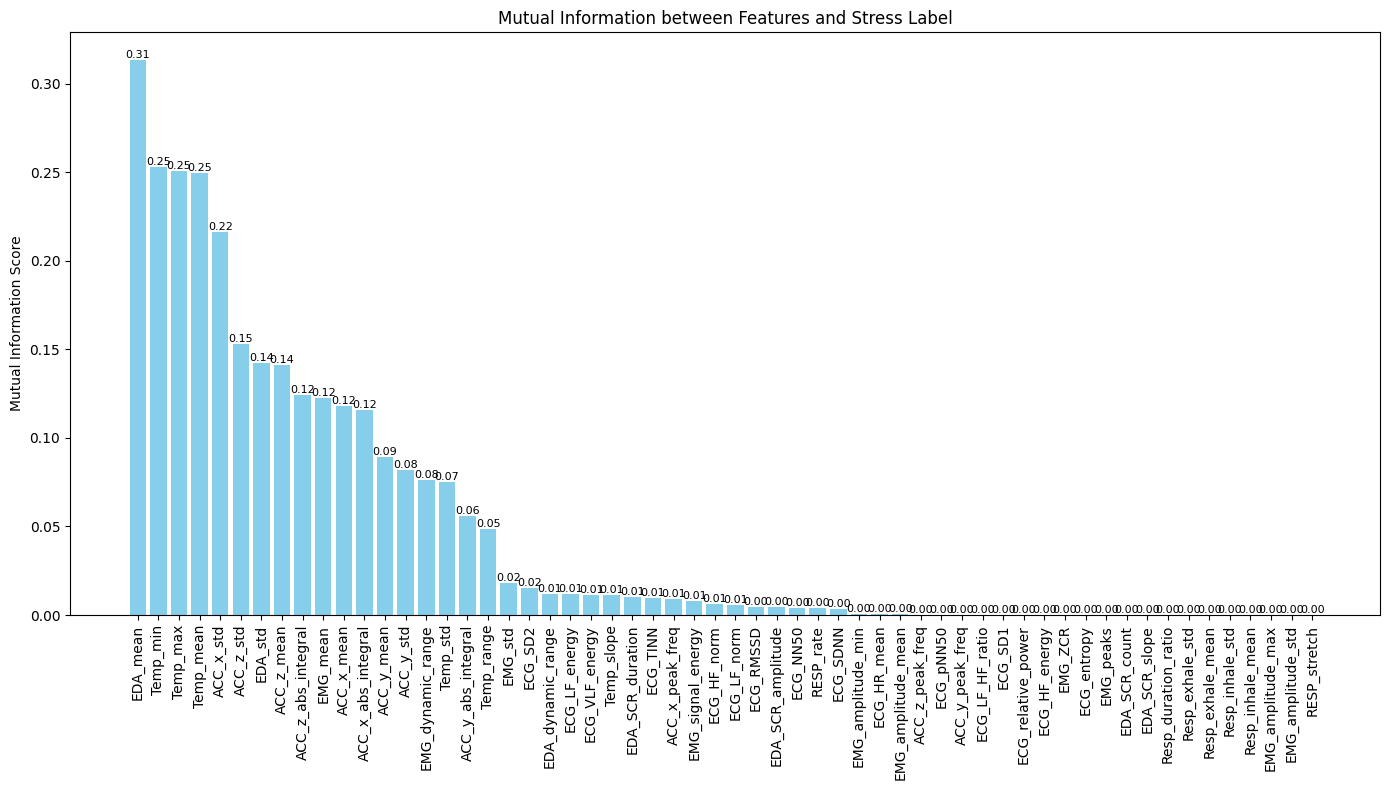

In [20]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Feature columns (excluding the target)
feature_columns = [
       'ACC_x_mean', 'ACC_x_std', 'ACC_x_abs_integral', 'ACC_x_peak_freq',
       'ACC_y_mean', 'ACC_y_std', 'ACC_y_abs_integral', 'ACC_y_peak_freq',
       'ACC_z_mean', 'ACC_z_std', 'ACC_z_abs_integral', 'ACC_z_peak_freq',
       'ECG_HR_mean', 'ECG_SDNN', 'ECG_RMSSD', 'ECG_NN50', 'ECG_pNN50',
       'ECG_TINN', 'ECG_VLF_energy', 'ECG_LF_energy', 'ECG_HF_energy',
       'ECG_LF_HF_ratio', 'ECG_LF_norm', 'ECG_HF_norm', 'ECG_relative_power',
       'ECG_SD1', 'ECG_SD2', 'ECG_entropy', 'EDA_mean', 'EDA_std',
       'EDA_SCR_count', 'EDA_SCR_amplitude', 'EDA_SCR_duration',
       'EDA_SCR_slope', 'EDA_dynamic_range', 'EMG_mean', 'EMG_std',
       'EMG_dynamic_range', 'EMG_ZCR', 'EMG_peaks', 'EMG_signal_energy',
       'EMG_amplitude_mean', 'EMG_amplitude_std', 'EMG_amplitude_max',
       'EMG_amplitude_min', 'Resp_inhale_mean', 'Resp_inhale_std',
       'Resp_exhale_mean', 'Resp_exhale_std', 'Resp_duration_ratio',
       'RESP_stretch', 'RESP_rate', 'Temp_mean', 'Temp_std', 'Temp_min',
       'Temp_max', 'Temp_range', 'Temp_slope',
]

# Target
target_column = 'stress_label'

# Extract features and labels
X = df3[feature_columns]
y = df3[target_column]

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
mi_series = pd.Series(mi_scores, index=feature_columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(14, 8))
bars = plt.bar(mi_series.index, mi_series.values, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information between Features and Stress Label")

# Annotate each bar with its score
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [21]:
mi_series

EDA_mean               0.313428
Temp_min               0.252791
Temp_max               0.251004
Temp_mean              0.249830
ACC_x_std              0.216277
ACC_z_std              0.153162
EDA_std                0.142221
ACC_z_mean             0.140963
ACC_z_abs_integral     0.124395
EMG_mean               0.122822
ACC_x_mean             0.118079
ACC_x_abs_integral     0.115595
ACC_y_mean             0.089434
ACC_y_std              0.081705
EMG_dynamic_range      0.076354
Temp_std               0.074993
ACC_y_abs_integral     0.055910
Temp_range             0.048692
EMG_std                0.017877
ECG_SD2                0.015180
EDA_dynamic_range      0.012094
ECG_LF_energy          0.011607
ECG_VLF_energy         0.011448
Temp_slope             0.011168
EDA_SCR_duration       0.009909
ECG_TINN               0.009494
ACC_x_peak_freq        0.009055
EMG_signal_energy      0.008182
ECG_HF_norm            0.006244
ECG_LF_norm            0.005509
ECG_RMSSD              0.004655
EDA_SCR_

In [22]:
# List of columns to extract (from your output)
features_to_extract = [
    'EDA_mean', 'Temp_min', 'Temp_max', 'Temp_mean', 'ACC_x_std',
    'ACC_z_std', 'EDA_std', 'ACC_z_mean', 'ACC_z_abs_integral', 'EMG_mean',
    'ACC_x_mean', 'ACC_x_abs_integral', 'ACC_y_mean', 'ACC_y_std',
    'EMG_dynamic_range', 'Temp_std', 'ACC_y_abs_integral', 'Temp_range',
    'EMG_std', 'ECG_SD2', 'EDA_dynamic_range', 'ECG_LF_energy',
    'ECG_VLF_energy', 'Temp_slope'
]

# Add the target column
features_to_extract.append('stress_label')

# Create the new dataframe
df4 = df3[features_to_extract].copy()

In [23]:
df4.columns

Index(['EDA_mean', 'Temp_min', 'Temp_max', 'Temp_mean', 'ACC_x_std',
       'ACC_z_std', 'EDA_std', 'ACC_z_mean', 'ACC_z_abs_integral', 'EMG_mean',
       'ACC_x_mean', 'ACC_x_abs_integral', 'ACC_y_mean', 'ACC_y_std',
       'EMG_dynamic_range', 'Temp_std', 'ACC_y_abs_integral', 'Temp_range',
       'EMG_std', 'ECG_SD2', 'EDA_dynamic_range', 'ECG_LF_energy',
       'ECG_VLF_energy', 'Temp_slope', 'stress_label'],
      dtype='object')

In [24]:
# Convert 'stress_label' to integer
df4['stress_label'] = df4['stress_label'].astype(int)

In [25]:
df4.dtypes

EDA_mean              float64
Temp_min              float64
Temp_max              float64
Temp_mean             float32
ACC_x_std             float64
ACC_z_std             float64
EDA_std               float64
ACC_z_mean            float64
ACC_z_abs_integral    float64
EMG_mean              float64
ACC_x_mean            float64
ACC_x_abs_integral    float64
ACC_y_mean            float64
ACC_y_std             float64
EMG_dynamic_range     float64
Temp_std              float64
ACC_y_abs_integral    float64
Temp_range            float64
EMG_std               float64
ECG_SD2                 int64
EDA_dynamic_range       int64
ECG_LF_energy           int64
ECG_VLF_energy          int64
Temp_slope              int64
stress_label            int64
dtype: object

# CLASSIFICATION REPORTS: Without Oversampling 

In [26]:
df4.columns

Index(['EDA_mean', 'Temp_min', 'Temp_max', 'Temp_mean', 'ACC_x_std',
       'ACC_z_std', 'EDA_std', 'ACC_z_mean', 'ACC_z_abs_integral', 'EMG_mean',
       'ACC_x_mean', 'ACC_x_abs_integral', 'ACC_y_mean', 'ACC_y_std',
       'EMG_dynamic_range', 'Temp_std', 'ACC_y_abs_integral', 'Temp_range',
       'EMG_std', 'ECG_SD2', 'EDA_dynamic_range', 'ECG_LF_energy',
       'ECG_VLF_energy', 'Temp_slope', 'stress_label'],
      dtype='object')

In [27]:
df4['stress_label'].value_counts()

stress_label
0    1800
1     782
Name: count, dtype: int64

# 1. Decision Tree


TEST SET EVALUATION (DECISION TREE)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       192
           1       0.97      0.96      0.96        67

    accuracy                           0.98       259
   macro avg       0.98      0.97      0.97       259
weighted avg       0.98      0.98      0.98       259



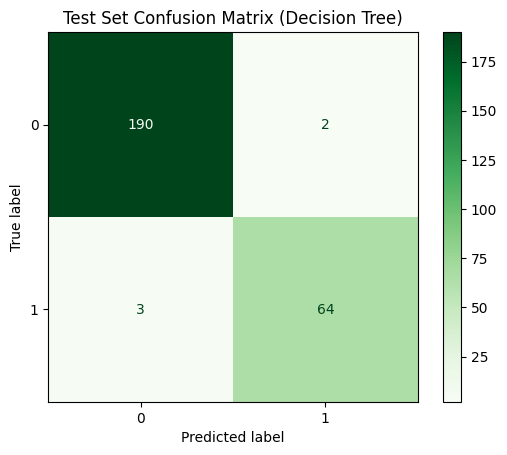

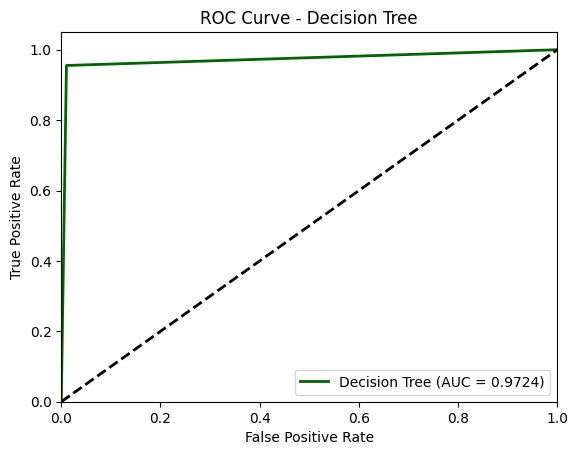

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# 3. Train Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (DECISION TREE)")
print("="*50)

# A. Classification Report
y_test_pred = dtree.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Test Set Confusion Matrix (Decision Tree)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = dtree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkgreen', 
         lw=2, 
         label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

1A. 80:20 Split


TEST SET EVALUATION (DECISION TREE)

Classification Report:
              precision    recall  f1-score   support

           0     0.9837    0.9890    0.9863       365
           1     0.9733    0.9605    0.9669       152

    accuracy                         0.9807       517
   macro avg     0.9785    0.9748    0.9766       517
weighted avg     0.9806    0.9807    0.9806       517



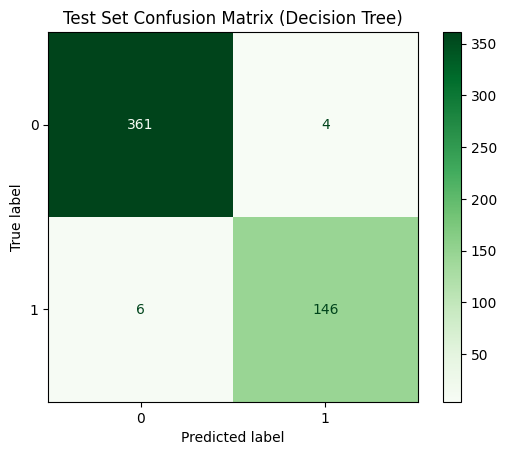

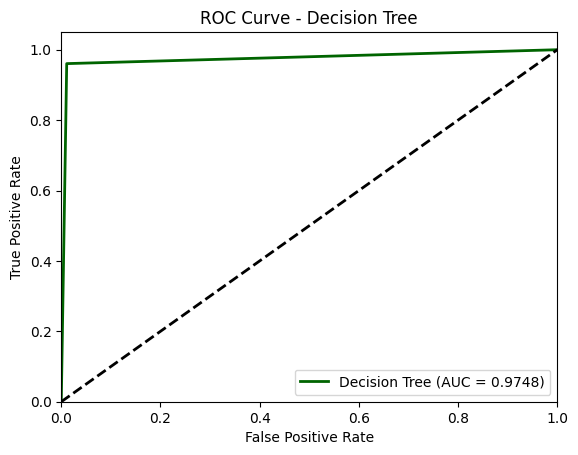

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (DECISION TREE)")
print("="*50)

# A. Classification Report
y_test_pred = dtree.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Test Set Confusion Matrix (Decision Tree)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = dtree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkgreen', 
         lw=2, 
         label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# 2. Logistic Regression


TEST SET EVALUATION

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       192
           1       0.85      0.67      0.75        67

    accuracy                           0.88       259
   macro avg       0.87      0.81      0.84       259
weighted avg       0.88      0.88      0.88       259



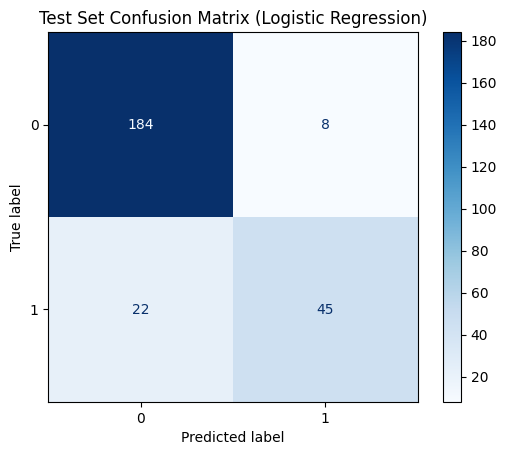

ValueError: Found input variables with inconsistent numbers of samples: [259, 517]

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3. Train Logistic Regression classifier
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION")
print("="*50)

# A. Classification Report
y_test_pred = logreg.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix (Logistic Regression)")
plt.show()

# C. ROC-AUC Curve
# Generate ROC curve with custom legend (4 decimal places)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         lw=2, 
         label=f'Classifier (AUC = {roc_auc:.4f})')  # Force 4 decimal places
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


2B. 80:20 split

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Logistic Regression classifier
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (LOGISTIC REGRESSION)")
print("="*50)

# A. Classification Report
y_test_pred = lr.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix (Logistic Regression)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', 
         lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# 3. K-Nearest Neighbours

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# Standardize features (critical for KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3. Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune this parameter
knn.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (KNN)")
print("="*50)

# A. Classification Report
y_test_pred = knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Test Set Confusion Matrix (KNN)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkviolet', 
         lw=2, 
         label=f'KNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()

3B. 80:20 split

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (KNN)")
print("="*50)

# A. Classification Report
y_test_pred = knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Test Set Confusion Matrix (KNN)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', 
         lw=2, 
         label=f'KNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()


# 4. Linear Discriminant Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# Standardize features (recommended for LDA)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3. Train LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (LDA)")
print("="*50)

# A. Classification Report
y_test_pred = lda.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.title("Test Set Confusion Matrix (LDA)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = lda.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkred', 
         lw=2, 
         label=f'LDA (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Linear Discriminant Analysis')
plt.legend(loc="lower right")
plt.show()

# D. Feature Coefficients (LDA specific)
coefficients = pd.Series(lda.coef_[0], index=X.columns)
coefficients.sort_values(ascending=False).plot(kind='bar', color='red')
plt.title("LDA Feature Coefficients")
plt.show()

4B. 80:20 Split

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (LDA)")
print("="*50)

# A. Classification Report
y_test_pred = lda.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Test Set Confusion Matrix (LDA)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = lda.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         lw=2, 
         label=f'LDA (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LDA')
plt.legend(loc="lower right")
plt.show()


# 5. Naive Bayes Classifier

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# Standardize features (important for GaussianNB)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# 3. Train Naive Bayes classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (Naive Bayes)")
print("="*50)

# A. Classification Report
y_test_pred = nb.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Test Set Confusion Matrix (Naive Bayes)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = nb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', 
         lw=2, 
         label=f'Naive Bayes (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

5B. 80:20 Split

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (GAUSSIAN NAIVE BAYES)")
print("="*50)

# A. Classification Report
y_test_pred = gnb.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.title("Test Set Confusion Matrix (Gaussian NB)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkred', 
         lw=2, 
         label=f'Gaussian NB (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()


# 6. Artificial Neural Network

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Build the ANN model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# 4. Compile the model
optimizer = Adagrad(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=2)

# 6. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (ANN)")
print("="*50)

# Predict class labels
y_test_proba = model.predict(X_test).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# A. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix (ANN)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', 
         lw=2, 
         label=f'ANN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ANN')
plt.legend(loc="lower right")
plt.show()


# APPLY SMOTE

In [ ]:
pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
!pip install --quiet --upgrade scikit-learn==1.4.2 imbalanced-learn==0.12.3

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df4.drop('stress_label', axis=1)
y = df4['stress_label']

# Apply SMOTE on entire data (not splitting here since you want balanced df5)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine back into a new dataframe
df5 = pd.DataFrame(X_resampled, columns=X.columns)
df5['stress_label'] = y_resampled

# Check the new class distribution
print(df5['stress_label'].value_counts())


# CLASSIFICATION REPORTS: With SMOTE

# A. Decision Tree

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (DECISION TREE)")
print("="*50)

# A. Classification Report
y_test_pred = dtree.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title("Test Set Confusion Matrix (Decision Tree)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = dtree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkgreen', 
         lw=2, 
         label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# B. Logistic Regression

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Logistic Regression classifier
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (LOGISTIC REGRESSION)")
print("="*50)

# A. Classification Report
y_test_pred = lr.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix (Logistic Regression)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', 
         lw=2, 
         label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


# C. K-Nearest Neighbours

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (KNN)")
print("="*50)

# A. Classification Report
y_test_pred = knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Test Set Confusion Matrix (KNN)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', 
         lw=2, 
         label=f'KNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()


# D. Linear Discriminant Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (LDA)")
print("="*50)

# A. Classification Report
y_test_pred = lda.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title("Test Set Confusion Matrix (LDA)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = lda.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', 
         lw=2, 
         label=f'LDA (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LDA')
plt.legend(loc="lower right")
plt.show()


# E. Naive Bayes Classifier

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Train Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# 4. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (GAUSSIAN NAIVE BAYES)")
print("="*50)

# A. Classification Report
y_test_pred = gnb.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.title("Test Set Confusion Matrix (Gaussian NB)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
y_test_proba = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkred', 
         lw=2, 
         label=f'Gaussian NB (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()


# F. Artificial Neural Network

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adagrad

# 1. Load and prepare the data
# Assuming df4 is already loaded with features and 'stress_label' target
X = df5.drop('stress_label', axis=1)
y = df5['stress_label']

# 2. Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Build the ANN model
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# 4. Compile the model
optimizer = Adagrad(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 5. Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=64, verbose=2)

# 6. Evaluate on TEST SET
print("\n" + "="*50)
print("TEST SET EVALUATION (ANN)")
print("="*50)

# Predict class labels
y_test_proba = model.predict(X_test).flatten()
y_test_pred = (y_test_proba >= 0.5).astype(int)

# A. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# B. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Test Set Confusion Matrix (ANN)")
plt.show()

# C. ROC-AUC Curve (with 4 decimal places)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', 
         lw=2, 
         label=f'ANN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ANN')
plt.legend(loc="lower right")
plt.show()


# APPLY HDAO

In [ ]:
# --- Top of your notebook ---
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Avoid OpenMP crash
os.environ["NUMEXPR_NUM_THREADS"] = "1"   # Optional: for numexpr
os.environ["OMP_NUM_THREADS"] = "1"       # Optional: for OMP libs

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.decomposition import PCA

# ----- PARAMETERS -----
radius_quantile = 0.05  # allows for broader synthetic point spread
use_pca = True          # set to False if PCA not needed
pca_variance = 0.95     # how much variance PCA should retain
n_neighbors_lof = 10    # for outlier detection

# ----- FUNCTIONS -----

def compute_local_density(X, k=5):
    """Estimate local density using k-NN average distance."""
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    mean_dist = distances[:, 1:].mean(axis=1)  # exclude self
    density = 1 / (mean_dist + 1e-10)
    return density

def remove_outliers(X, contamination=0.05):
    """Remove outliers using Local Outlier Factor."""
    lof = LocalOutlierFactor(n_neighbors=n_neighbors_lof, contamination=contamination)
    mask = lof.fit_predict(X) == 1  # keep only inliers
    return X[mask]

def generate_gaussian_samples(mean, cov, n_points):
    """Generate synthetic samples from a multivariate Gaussian."""
    dim = mean.shape[0]
    cov += 1e-6 * np.eye(dim)  # regularization to avoid singular matrix
    return np.random.multivariate_normal(mean, cov, size=n_points)

# ----- MAIN HDAO PROCEDURE -----

def improved_HDAO(df_new):
    new_samples_list = []
    df_new['stress_label'] = df_new['stress_label'].astype(int)
    actual_label_counts = df_new['stress_label'].value_counts()
    max_count = actual_label_counts.max()

    for label in actual_label_counts.index:
        print(f"Processing class {label}")
        class_data = df_new[df_new['stress_label'] == label].iloc[:, :-1].values
        n_samples = class_data.shape[0]

        # Step 1: Outlier Removal
        class_data = remove_outliers(class_data, contamination=0.05)
        if class_data.shape[0] < 10:
            print(f"Warning: Too few inliers in class {label}, skipping")
            continue

        # Step 2: PCA (optional)
        if use_pca:
            pca = PCA(n_components=pca_variance)
            class_data_pca = pca.fit_transform(class_data)
        else:
            class_data_pca = class_data

        # Step 3: Density-weighted centroid
        density_weights = compute_local_density(class_data_pca, k=5)
        weighted_sum = np.sum(density_weights[:, None] * class_data_pca, axis=0)
        cDWC = weighted_sum / np.sum(density_weights)

        # Step 4: Radius from centroid
        distances = np.linalg.norm(class_data_pca - cDWC, axis=1)
        radius = np.quantile(distances, radius_quantile)

        # Step 5: Class covariance (in PCA space or original)
        cov_matrix = np.atleast_2d(np.cov(class_data_pca.T))

        # Step 6: Number of synthetic points to generate
        n_generate = max_count - n_samples
        if n_generate > 0:
            synthetic_points = generate_gaussian_samples(cDWC, cov_matrix, n_generate)

            if use_pca:
                synthetic_points = pca.inverse_transform(synthetic_points)

            synthetic_df = pd.DataFrame(synthetic_points, columns=df_new.columns[:-1])
            synthetic_df['stress_label'] = label
            new_samples_list.append(synthetic_df)

    # Combine original + synthetic
    df_augmented = pd.concat([df_new] + new_samples_list, ignore_index=True)

    # Class balance check
    final_label_counts = df_augmented['stress_label'].value_counts().sort_index()
    print("\nFinal Class Counts:\n", final_label_counts)
    print("New dataset shape:", df_augmented.shape)

    return df_augmented


In [ ]:
df6 = improved_HDAO(df4)

# CLASSIFICATION REPORTS: With HDAO

# a. Decision Tree

# b. Logistic Regression

# c. K-Nearest Neighbours

# d. Linear Discriminant Analysis 

# e. Naive Bayes Classifier

# f. Artificial Neural Network